`cd project/seniorthesis/notebooks`

`conda list PyCO2SYS`

`pip install PyCO2SYS`

`pip install git+https://github.com/jbusecke/cmip6_preprocessing.git`

`mv *.png ../figures`

In [19]:
from scipy.io import loadmat
import xarray as xr
import xesmf as xe
from cmip6_preprocessing.preprocessing import combined_preprocessing
import PyCO2SYS as pyco2 # i have to install this package through terminal for it to work
import intake
import matplotlib.pyplot as plt
import numpy as np
import warnings
import gsw
from cmip6_preprocessing.postprocessing import combine_datasets
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import cmocean
import matplotlib.path as mpath
from cmip6_preprocessing.postprocessing import combine_datasets
from cmip6_preprocessing.postprocessing import merge_variables
from dask.diagnostics import ProgressBar
from xgcm import Grid
from xhistogram.xarray import histogram
import pandas as pd
from scipy.io import netcdf
import netCDF4 as nc


# Importing Bushinsky Observations
Copied pretty much directly from Graeme
https://github.com/gmacgilchrist/so_decadal_variability/blob/d8422102ce2d41e4218db393510f7507d360a574/notebooks/dev_carbonflux.ipynb


In [45]:

filename = 'MPI-SOM_FFN_SOCCOMv2018weighted_minus_4uatm_offset.nc'
nds = nc.Dataset(filename)
# ds = xr.open_dataset(rootdir+filename)

In [46]:
times = pd.date_range('1982-01-01','2017-12-31',freq='M')
ds = xr.Dataset()
ds['fgco2'] = xr.DataArray(nds['fgco2'][:],dims=['time','lat','lon'])
ds['fgco2'] = ds['fgco2'].where(ds['fgco2']<1E19,np.nan)
# ds['seamask'] = xr.DataArray(nds['seamask'][:],dims=['lat','lon'])
ds = ds.assign_coords({'time':times,'lat':nds['lat'][:],'lon':nds['lon'][:]})

<ipython-input-46-765807935225>:3: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  ds['fgco2'] = xr.DataArray(nds['fgco2'][:],dims=['time','lat','lon'])


In [25]:
obs_fgco2 = ds

I think this integrates over area

In [48]:


from xgcm import Grid
from xgcm.autogenerate import generate_grid_ds



# Creating an xgcm grid
def _degrees_to_meters(dlon, dlat, lon, lat):
        """Converts lat/lon differentials into distances in meters
        PARAMETERS
        ----------
        dlon : xarray.DataArray longitude differentials
        dlat : xarray.DataArray latitude differentials
        lon  : xarray.DataArray longitude values
        lat  : xarray.DataArray latitude values
        RETURNS
        -------
        dx  : xarray.DataArray distance inferred from dlon
        dy  : xarray.DataArray distance inferred from dlat
        """

        distance_1deg_equator = 111000.0
        dx = dlon * xr.ufuncs.cos(xr.ufuncs.deg2rad(lat)) * distance_1deg_equator
        dy = ((lon * 0) + 1) * dlat * distance_1deg_equator
        return dx, dy



gridlon='lon'
gridlat='lat'
ds = generate_grid_ds(ds, {'X':gridlon,'Y':gridlat})
xgrid = Grid(ds, periodic=['X'])

# Get horizontal distances
dlonG = xgrid.diff(ds[gridlon], 'X', boundary_discontinuity=360)
dlonC = xgrid.diff(ds[gridlon+'_left'], 'X', boundary_discontinuity=360)

dlatG = xgrid.diff(ds[gridlat], 'Y', boundary='fill', fill_value=np.nan)
dlatC = xgrid.diff(ds[gridlat+'_left'], 'Y', boundary='fill', fill_value=np.nan)

ds['dxG'], ds['dyG'] = _degrees_to_meters(dlonG, dlatG, ds[gridlon], ds[gridlat])
ds['dxC'], ds['dyC'] = _degrees_to_meters(dlonC, dlatC, ds[gridlon], ds[gridlat])

ds['daC'] = ds['dxC']*ds['dyC']



f = (ds['fgco2']*ds['daC'])

In [49]:
f

<xarray.DataArray (time: 432, lat: 180, lon: 360)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1982-01-31 1982-02-28 ... 2017-12-31
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5

In [3]:
haumann = loadmat('glodapv2_2016b_mapped_ppco2_gamman.mat')
lev = haumann['dpth']
gamman = haumann['gamman']
lat = haumann['lat']
lon = haumann['lon']
ppco2 = haumann['ppco2']
vol = haumann['vol']

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols=1, figsize=[10,10], subplot_kw={'projection':ccrs.SouthPolarStereo()})
crs_plot = ccrs.SouthPolarStereo()
crs_source = ccrs.PlateCarree()

ax.add_feature(cfeature.LAND,zorder=10,facecolor='darkgray')
ax.set_extent([-180, 180, -90, -30], crs_source)
# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
    
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
    
    ax.gridlines()
    ax.coastlines()
    
    title=name
    ax.set_title(title,fontsize=34,pad = 1)
    
    lat = ds['fgco2'].lat.transpose('y','x')
    lon = ds['fgco2'].lon.transpose('y','x')
    X = lon
    Y = lat
    
    conversion = 3.1536e7 * 83.3
    # 3.1536e7 seconds per year
    # 83.3 mol C per kg -- 12 gC/mol
    
    Z = ds['fgco2']*conversion
    rho = ds['sigma2'].isel(lev = 0)
    rho = rho.transpose('x','y')
#     rho.assign_coords({'lat': Y})
#     rho.assign_coords({'lon': X})
#     rho = rho.transpose('x','y')
#     rho.assign_coords({'lat': Y})
#     rho.assign_coords({'lon': X})
# #     rho = rho.transpose('y','x')
# #     print(Z)
# #     print(rho)
    
    
    im = ax.pcolormesh(X,Y,-1*Z,cmap='RdBu_r', transform = crs_source, shading = 'auto', vmin = -3, vmax = 3)
    if name == 'UKESM1-0-LL.gn.historical.Omon' or name =='CanESM5-CanOE.gn.historical.Omon' or name =='CNRM-ESM2-1.gn.historical.Omon' or name == 'CanESM5.gn.historical.Omon' or name == 'IPSL-CM6A-LR.gn.historical.Omon':
        CS = ax.contour(rho.lon,rho.lat,rho,transform=crs_source,levels=[35, 35.5, 36, 36.5, 36.8],colors='g', linewidths = 3)
    else:
        CS = ax.contour(rho.lon.transpose('y','x'),rho.lat.transpose('y','x'),rho.transpose('y','x'),transform=crs_source,levels=[35, 35.5, 36, 36.5],colors='g', linewidths = 3)
    
#     cbar_label = 'Surface Upward Flux of Total CO\u2082 (mol/m\u00b2/yr)'
#     cbar = plt.colorbar(im,ax = ax, orientation='horizontal',fraction = 0.05, pad=0.05)
#     cbar.set_label(cbar_label, fontsize = 20)
#     cbar.ax.tick_params(labelsize=18)
    ax.clabel(CS, inline=1, fontsize=24)
    
    ax_idx += 1


In [ ]:
newcoords = {'x':lon,'y':lat, 'z':lev}
ppco2.assign_coords(**newcoords)

In [19]:
xr.DataArray(data=ppco2,
            dims=["x", "y", "lev"],
            coords=dict(lon=(["x", "y"], lon), 
                        lat=(["x", "y"], lat), 
                        lev=lev)
            )

ValueError: Could not convert tuple of form (dims, data[, attrs, encoding]): (['x', 'y'], array([[[20.5, 20.5, 20.5, ..., 20.5, 20.5, 20.5],
        [20.5, 20.5, 20.5, ..., 20.5, 20.5, 20.5],
        [20.5, 20.5, 20.5, ..., 20.5, 20.5, 20.5],
        ...,
        [20.5, 20.5, 20.5, ..., 20.5, 20.5, 20.5],
        [20.5, 20.5, 20.5, ..., 20.5, 20.5, 20.5],
        [20.5, 20.5, 20.5, ..., 20.5, 20.5, 20.5]],

       [[21.5, 21.5, 21.5, ..., 21.5, 21.5, 21.5],
        [21.5, 21.5, 21.5, ..., 21.5, 21.5, 21.5],
        [21.5, 21.5, 21.5, ..., 21.5, 21.5, 21.5],
        ...,
        [21.5, 21.5, 21.5, ..., 21.5, 21.5, 21.5],
        [21.5, 21.5, 21.5, ..., 21.5, 21.5, 21.5],
        [21.5, 21.5, 21.5, ..., 21.5, 21.5, 21.5]],

       [[22.5, 22.5, 22.5, ..., 22.5, 22.5, 22.5],
        [22.5, 22.5, 22.5, ..., 22.5, 22.5, 22.5],
        [22.5, 22.5, 22.5, ..., 22.5, 22.5, 22.5],
        ...,
        [22.5, 22.5, 22.5, ..., 22.5, 22.5, 22.5],
        [22.5, 22.5, 22.5, ..., 22.5, 22.5, 22.5],
        [22.5, 22.5, 22.5, ..., 22.5, 22.5, 22.5]],

       ...,

       [[17.5, 17.5, 17.5, ..., 17.5, 17.5, 17.5],
        [17.5, 17.5, 17.5, ..., 17.5, 17.5, 17.5],
        [17.5, 17.5, 17.5, ..., 17.5, 17.5, 17.5],
        ...,
        [17.5, 17.5, 17.5, ..., 17.5, 17.5, 17.5],
        [17.5, 17.5, 17.5, ..., 17.5, 17.5, 17.5],
        [17.5, 17.5, 17.5, ..., 17.5, 17.5, 17.5]],

       [[18.5, 18.5, 18.5, ..., 18.5, 18.5, 18.5],
        [18.5, 18.5, 18.5, ..., 18.5, 18.5, 18.5],
        [18.5, 18.5, 18.5, ..., 18.5, 18.5, 18.5],
        ...,
        [18.5, 18.5, 18.5, ..., 18.5, 18.5, 18.5],
        [18.5, 18.5, 18.5, ..., 18.5, 18.5, 18.5],
        [18.5, 18.5, 18.5, ..., 18.5, 18.5, 18.5]],

       [[19.5, 19.5, 19.5, ..., 19.5, 19.5, 19.5],
        [19.5, 19.5, 19.5, ..., 19.5, 19.5, 19.5],
        [19.5, 19.5, 19.5, ..., 19.5, 19.5, 19.5],
        ...,
        [19.5, 19.5, 19.5, ..., 19.5, 19.5, 19.5],
        [19.5, 19.5, 19.5, ..., 19.5, 19.5, 19.5],
        [19.5, 19.5, 19.5, ..., 19.5, 19.5, 19.5]]])) to Variable.

# `gn` `fgco2`
I have to search for all the variables because I need to same ensemble member as all the other plots

In [11]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")

variables = ['fgco2', 'dissic', 'talk', 'thetao', 'so']
z_kwargs = {'consolidated': True, 'use_cftime': True}
query = dict(experiment_id=['historical'], 
             table_id=['Omon'], 
             variable_id=variables,
             grid_label=['gn'],
              source_id=['IPSL-CM6A-LR', 
#                          'MPI-ESM1-2-LR', 
                         'CNRM-ESM2-1', 
                         'CanESM5', 
#                          'MPI-ESM1-2-HR', 
#                          'CMCC-ESM2', 
#                          'GISS-E2-1-G', 
                         'UKESM1-0-LL',
#                          'ACCESS-ESM1-5', 
                         'CanESM5-CanOE' 
#                          'GISS-E2-1-G-CC',
#                          'MPI-ESM-1-2-HAM'
                        ]
            )


cat = col.search(**query)

# print(cat.df['source_id'].unique())
dd_gn = cat.to_dataset_dict(zarr_kwargs=z_kwargs, storage_options={'token': 'anon'},
                                preprocess=combined_preprocessing, aggregate=False)

dd_gn = merge_variables(dd_gn)
# list(dd_new.keys())

temp={}
for name,item in dd_gn.items():
    #print(name)
    #print(item.data_vars)
    present = item.data_vars
    if all(i in present for i in variables):
        #print(name)
        temp[name]=item
dd_gn = temp


def pick_first_member(ds_list, **kwargs):
    return ds_list[0]

dd_gn = combine_datasets(
    dd_gn,
    pick_first_member,
    match_attrs=['source_id', 'grid_label', 'experiment_id', 'table_id']
)
list(dd_gn.keys())
# dd_new_new_gn


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


/srv/conda/envs/notebook/lib/python3.8/site-packages/cmip6_preprocessing/postprocessing.py:138: UserWarning: CMIP.IPSL.IPSL-CM6A-LR.historical.r2i1p1f1.Omon.gn.none.so failed to combine with :indexes along dimension 'lev' are not equal
  warnings.warn(f"{cmip6_dataset_id(ds)} failed to combine with :{e}")
/srv/conda/envs/notebook/lib/python3.8/site-packages/cmip6_preprocessing/postprocessing.py:138: UserWarning: CMIP.IPSL.IPSL-CM6A-LR.historical.r10i1p1f1.Omon.gn.none.fgco2 failed to combine with :cannot compare cftime.DatetimeGregorian(1850, 1, 16, 12, 0, 0, 0) and cftime.DatetimeProlepticGregorian(1850, 1, 16, 12, 0, 0, 0) (different calendars)
  warnings.warn(f"{cmip6_dataset_id(ds)} failed to combine with :{e}")
/srv/conda/envs/notebook/lib/python3.8/site-packages/cmip6_preprocessing/postprocessing.py:138: UserWarning: CMIP.MOHC.UKESM1-0-LL.historical.r12i1p1f2.Omon.gn.none.fgco2 failed to combine with :indexes along dimension 'time' are not equal
  warnings.warn(f"{cmip6_dataset_i

['IPSL-CM6A-LR.gn.historical.Omon',
 'UKESM1-0-LL.gn.historical.Omon',
 'CanESM5-CanOE.gn.historical.Omon',
 'CanESM5.gn.historical.Omon',
 'CNRM-ESM2-1.gn.historical.Omon']

In [12]:
# Regrid
targetgrid_ds = xe.util.grid_global(1.0, 1.0)
targetgrid_ds['lon'] = targetgrid_ds['lon']+180
targetgrid_ds['lon_b'] = targetgrid_ds['lon_b']+180
newcoords = {'x':targetgrid_ds['lon'][0,:],'y':targetgrid_ds['lat'][:,0]}

dd_regrid={}
for name,item in dd_gn.items():
    regridder = xe.Regridder(item, targetgrid_ds, 'bilinear', 
                         periodic=True, ignore_degenerate=True)
    ds_regridded = regridder(item).assign_coords(**newcoords).chunk({'time':120})
    dd_regrid[name]=ds_regridded
list(dd_regrid.keys())

/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:496: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:496: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:496: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:496: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply

['IPSL-CM6A-LR.gn.historical.Omon',
 'UKESM1-0-LL.gn.historical.Omon',
 'CanESM5-CanOE.gn.historical.Omon',
 'CanESM5.gn.historical.Omon',
 'CNRM-ESM2-1.gn.historical.Omon']

# `gr` datasets

In [13]:
variables = ['fgco2', 'dissic', 'talk', 'thetao', 'so']
z_kwargs = {'consolidated': True, 'use_cftime': True}
query = dict(experiment_id=['historical'], 
             table_id=['Omon'], 
             variable_id=variables,
             grid_label=['gr'],
              source_id=['GFDL-ESM4', 'CESM2-WACCM', 'CESM2', 
                         'CESM2-FV2', 'MRI-ESM2-0', 
                         'GFDL-CM4', 'CESM2-WACCM-FV2']
            )


cat = col.search(**query)

# print(cat.df['source_id'].unique())
dd_gr = cat.to_dataset_dict(zarr_kwargs=z_kwargs, storage_options={'token': 'anon'},
                                preprocess=combined_preprocessing, aggregate=False)

dd_gr = merge_variables(dd_gr)

temp={}
for name,item in dd_gr.items():
    #print(name)
    #print(item.data_vars)
    present = item.data_vars
    if all(i in present for i in variables):
        #print(name)
        temp[name]=item
dd_gr = temp
# list(dd_new_gr.keys())

dd_gr = combine_datasets(
    dd_gr,
    pick_first_member,
    match_attrs=['source_id', 'grid_label', 'experiment_id', 'table_id']
)
list(dd_gr.keys())
# dd_new_new_gr


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


/srv/conda/envs/notebook/lib/python3.8/site-packages/cmip6_preprocessing/postprocessing.py:138: UserWarning: CMIP.NCAR.CESM2-FV2.historical.r3i1p1f1.Omon.gr.none.so failed to combine with :indexes along dimension 'time' are not equal
  warnings.warn(f"{cmip6_dataset_id(ds)} failed to combine with :{e}")
/srv/conda/envs/notebook/lib/python3.8/site-packages/cmip6_preprocessing/postprocessing.py:138: UserWarning: CMIP.NCAR.CESM2-FV2.historical.r2i1p1f1.Omon.gr.none.thetao failed to combine with :indexes along dimension 'time' are not equal
  warnings.warn(f"{cmip6_dataset_id(ds)} failed to combine with :{e}")
/srv/conda/envs/notebook/lib/python3.8/site-packages/cmip6_preprocessing/postprocessing.py:138: UserWarning: CMIP.NCAR.CESM2-WACCM-FV2.historical.r3i1p1f1.Omon.gr.none.so failed to combine with :indexes along dimension 'time' are not equal
  warnings.warn(f"{cmip6_dataset_id(ds)} failed to combine with :{e}")
/srv/conda/envs/notebook/lib/python3.8/site-packages/cmip6_preprocessing/po

['CESM2-FV2.gr.historical.Omon',
 'CESM2-WACCM.gr.historical.Omon',
 'CESM2.gr.historical.Omon',
 'MRI-ESM2-0.gr.historical.Omon',
 'GFDL-CM4.gr.historical.Omon',
 'GFDL-ESM4.gr.historical.Omon',
 'CESM2-WACCM-FV2.gr.historical.Omon']

In [14]:
dd = {**dd_gr, **dd_regrid}
list(dd.keys())

['CESM2-FV2.gr.historical.Omon',
 'CESM2-WACCM.gr.historical.Omon',
 'CESM2.gr.historical.Omon',
 'MRI-ESM2-0.gr.historical.Omon',
 'GFDL-CM4.gr.historical.Omon',
 'GFDL-ESM4.gr.historical.Omon',
 'CESM2-WACCM-FV2.gr.historical.Omon',
 'IPSL-CM6A-LR.gn.historical.Omon',
 'UKESM1-0-LL.gn.historical.Omon',
 'CanESM5-CanOE.gn.historical.Omon',
 'CanESM5.gn.historical.Omon',
 'CNRM-ESM2-1.gn.historical.Omon']

In [6]:
def pick_first_member(ds_list, **kwargs):
    return ds_list[0]

variables = ['areacello']
z_kwargs = {'consolidated': True, 'use_cftime': True}
query = dict(experiment_id=['historical'], 
             table_id=['Ofx'], 
             variable_id=variables,
             grid_label=['gr'],
              source_id=['GFDL-ESM4']
            )


cat = col.search(**query)

# print(cat.df['source_id'].unique())
dd_A = cat.to_dataset_dict(zarr_kwargs=z_kwargs, storage_options={'token': 'anon'},
                                preprocess=combined_preprocessing, aggregate=False)

dd_A = merge_variables(dd_A)

temp={}
for name,item in dd_A.items():
    #print(name)
    #print(item.data_vars)
    present = item.data_vars
    if all(i in present for i in variables):
        #print(name)
        temp[name]=item
dd_A = temp
# list(dd_new_gr.keys())

dd_A = combine_datasets(
    dd_A,
    pick_first_member,
    match_attrs=['source_id', 'grid_label', 'experiment_id', 'table_id']
)
list(dd_A.keys())
# dd_new_new_gr


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


['GFDL-ESM4.gr.historical.Ofx']

In [52]:
A = dd_A['GFDL-ESM4.gr.historical.Ofx'].mean([ 'x'],keep_attrs=True).areacello
A

<xarray.DataArray 'areacello' (y: 180)>
dask.array<mean_agg-aggregate, shape=(180,), dtype=float32, chunksize=(180,), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Attributes:
    cell_methods:   area: sum
    comment:        Model data on the 1x1 grid includes values in all cells f...
    interp_method:  conserve_order1
    long_name:      Grid-Cell Area
    original_name:  areacello
    standard_name:  cell_area
    units:          m²

# Plotting recent `fgco2` with Bushinsky observations

/srv/conda/envs/notebook/lib/python3.8/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


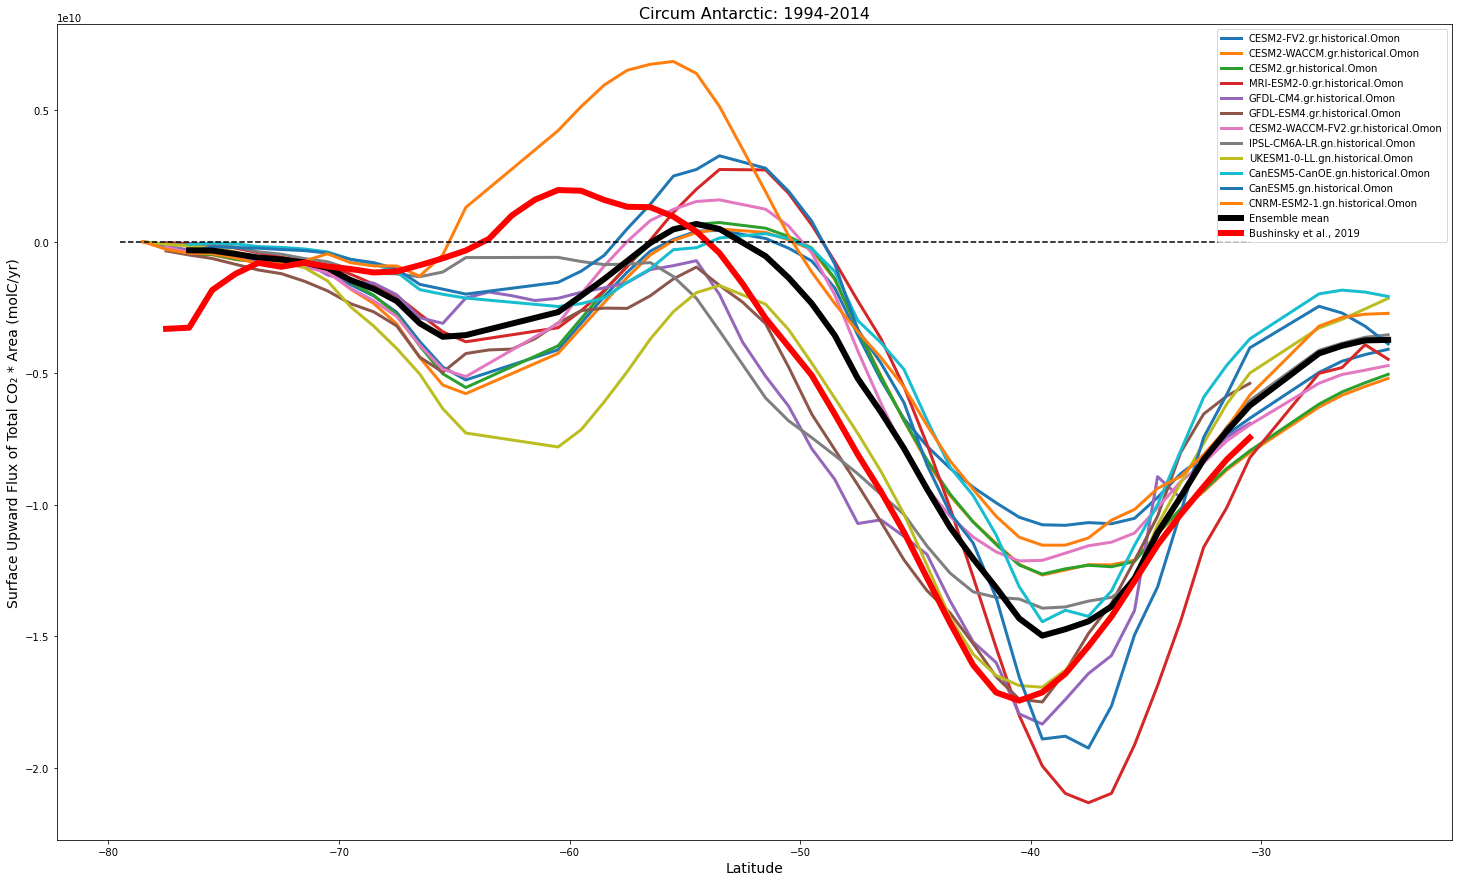

In [51]:
# d = dd['GFDL-CM4.gr.historical.Omon'].fgco2.mean(['x'],keep_attrs=True)
# d*A
temp = {}

conversion = 3.1536e7 * 83.3
for name, ds in dd.items():
    d = -1*ds.fgco2.isel(time = slice(1740, 1979)).mean(['time', 'x'],keep_attrs=True)*conversion
    ar = d*A
    temp[name]=ar
    

for name, ds in temp.items():
    plt.plot(ds.y[10:60], ds[10:60], label = name, lw = 3)
    plt.xlabel('Latitude')
    plt.ylabel('Surface Upward Flux of Total CO\u2082 (molC/m\u00b2/yr)')
    
mn = np.mean(list(temp.values()), axis=0)
plt.plot(ds.y[10:60], mn[10:60], lw = 6, label = 'Ensemble mean', color = 'black')
plt.xlabel('Latitude')
plt.ylabel('Surface Upward Flux of Total CO\u2082 (molC/m\u00b2/yr)')
r = f.mean(['time', 'lon'],keep_attrs=True)
plt.plot(r.lat[10:60], r[10:60], label = 'Bushinsky et al., 2019', lw = 6, color = 'red')
zr = xr.zeros_like(dd['CESM2-FV2.gr.historical.Omon'].fgco2.isel(time = slice(1740, 1979)).mean(['time'],keep_attrs=True))
zr.isel(x = 0)[10:60].plot(linestyle = 'dashed', color = 'black')
plt.xlabel('Latitude', fontsize = 14)
plt.ylabel('Surface Upward Flux of Total CO\u2082 * Area (molC/yr)', fontsize = 14)

plt.legend(
#     bbox_to_anchor=(1.05, 1), 
    loc='upper right'
#     , borderaxespad=0.
)
plt.title('Circum Antarctic: 1994-2014', fontsize = 16)
plt.rcParams["figure.figsize"] = (25,15)

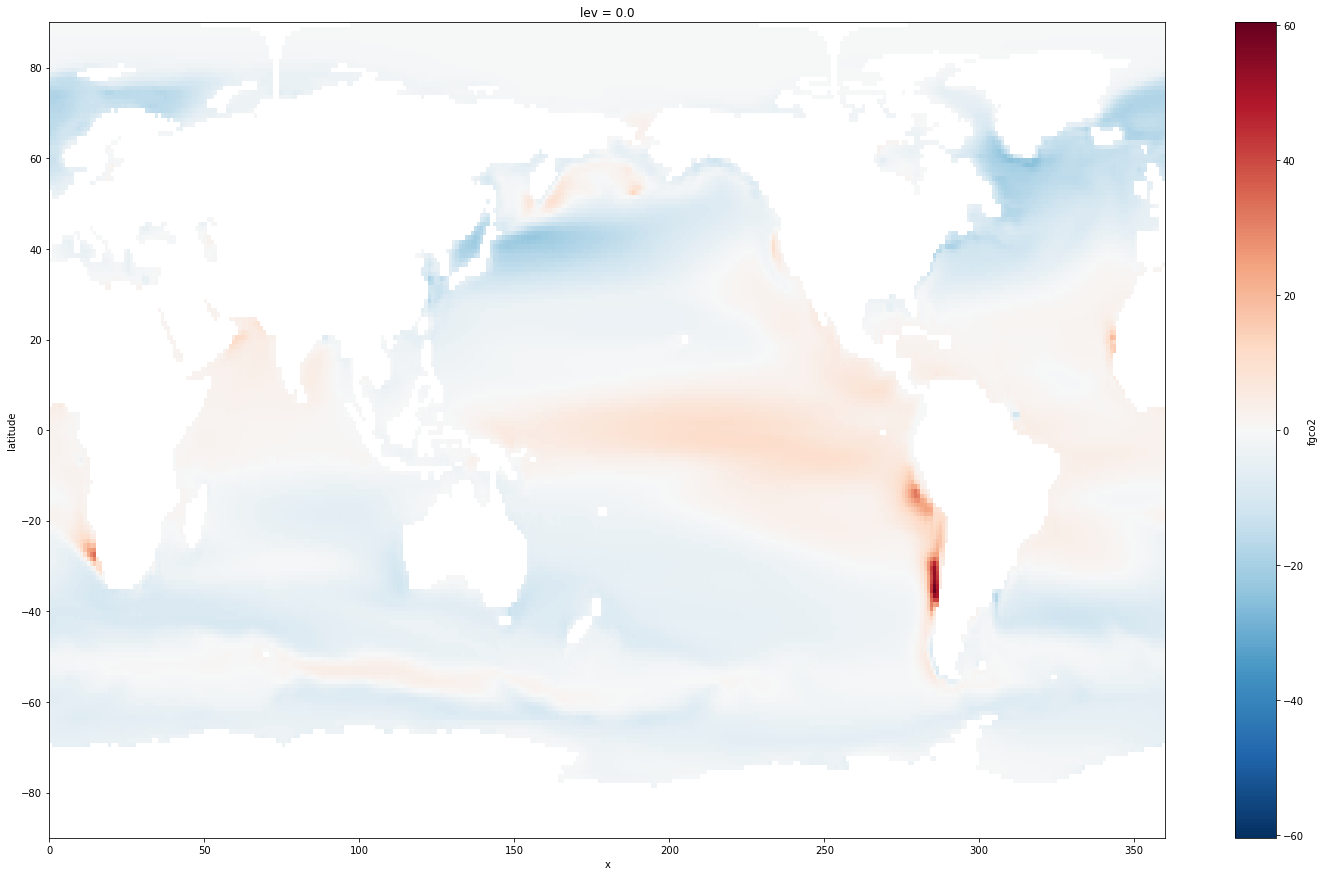

In [46]:
# p = -1*dd['UKESM1-0-LL.gn.historical.Omon'].fgco2.isel(time = slice(1740, 1979)).mean(['time', 'x'],keep_attrs=True)*conversion
# plt.plot(p.y[10:60], p[10:60])
q = -1*dd['UKESM1-0-LL.gn.historical.Omon'].fgco2.isel(time = slice(1740, 1979)).mean(['time'],keep_attrs=True)*conversion
q.plot()

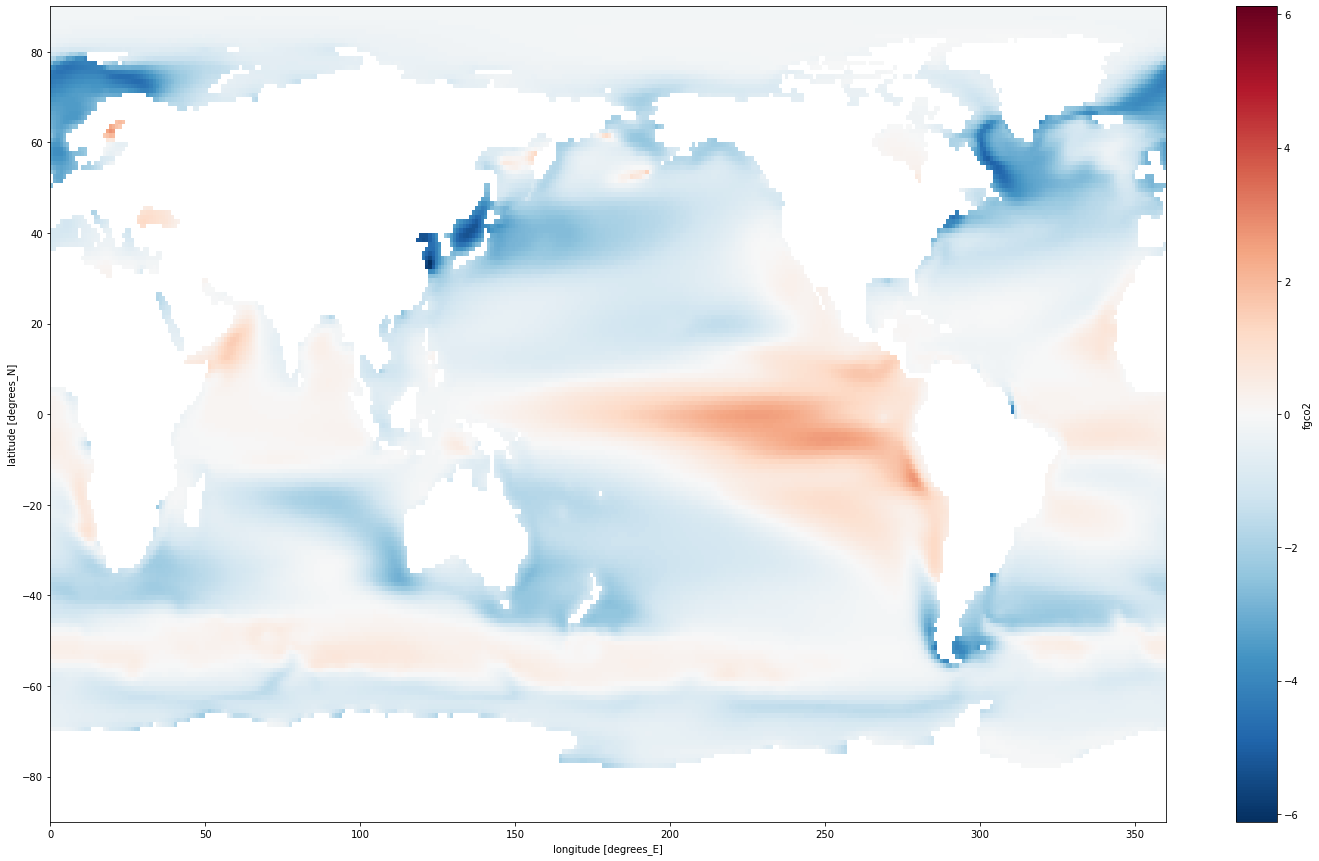

In [47]:
q = -1*dd['CESM2-FV2.gr.historical.Omon'].fgco2.isel(time = slice(1740, 1979)).mean(['time'],keep_attrs=True)*conversion
q.plot()

# Plotting `fgco2` 1850-1870 to make sure my method is right

/srv/conda/envs/notebook/lib/python3.8/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


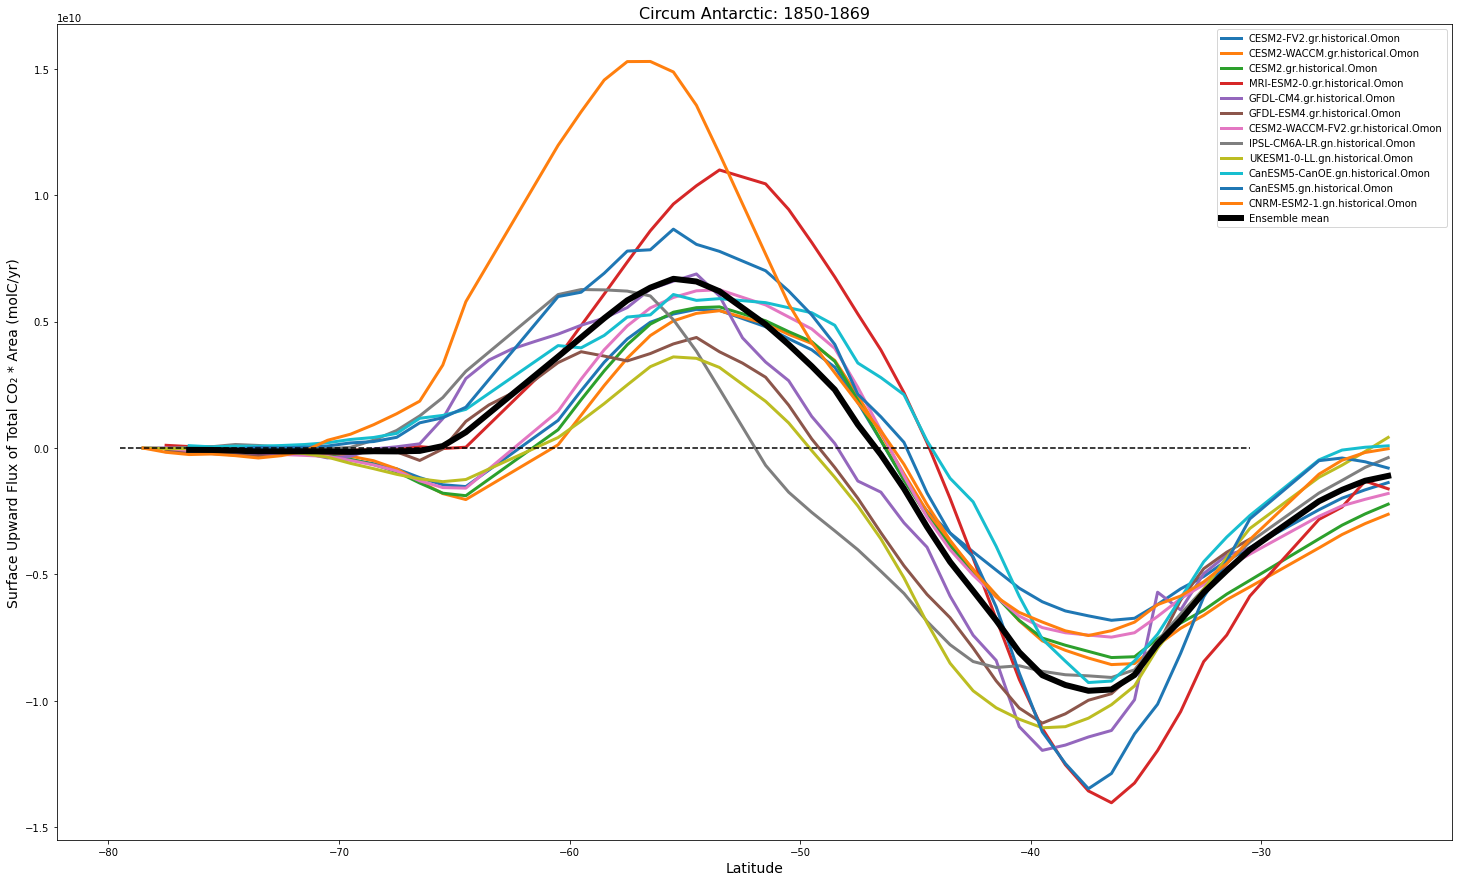

In [17]:
# d = dd['GFDL-CM4.gr.historical.Omon'].fgco2.mean(['x'],keep_attrs=True)
# d*A
temp = {}

conversion = 3.1536e7 * 83.3
for name, ds in dd.items():
    d = -1*ds.fgco2.isel(time = slice(0, 239)).mean(['time', 'x'],keep_attrs=True)*conversion
    ar = d*A
    temp[name]=ar
    

for name, ds in temp.items():
    plt.plot(ds.y[10:60], ds[10:60], label = name, lw = 3)
    plt.xlabel('Latitude')
    plt.ylabel('Surface Upward Flux of Total CO\u2082 (molC/m\u00b2/yr)')
    
mn = np.mean(list(temp.values()), axis=0)
plt.plot(ds.y[10:60], mn[10:60], lw = 6, label = 'Ensemble mean', color = 'black')
plt.xlabel('Latitude')
plt.ylabel('Surface Upward Flux of Total CO\u2082 (molC/m\u00b2/yr)')
zr = xr.zeros_like(dd['CESM2-FV2.gr.historical.Omon'].fgco2.isel(time = slice(1740, 1979)).mean(['time'],keep_attrs=True))
zr.isel(x = 0)[10:60].plot(linestyle = 'dashed', color = 'black')
plt.xlabel('Latitude', fontsize = 14)
plt.ylabel('Surface Upward Flux of Total CO\u2082 * Area (molC/yr)', fontsize = 14)

plt.legend(
#     bbox_to_anchor=(1.05, 1), 
    loc='upper right'
#     , borderaxespad=0.
)
plt.title('Circum Antarctic: 1850-1869', fontsize = 16)
plt.rcParams["figure.figsize"] = (25,15)